In [26]:
# game analysis
library(data.table)
library(ggplot2)
library(kableExtra)

In [55]:
# 游戏名称，开发商，机构评分，用户评分，发布时间，年龄分级，游戏类型
# 1. 全集，两个分数分析：机构评分 vs 用户评分，并且把差异最大的 10 个游戏名称显示出来；
# 2. 细分到开发商：聚焦在开发游戏最多的 10 个开发商，分析每个开发商两个评分的 boxplot；并且显示这 10 个开发商所有游戏的最低评分的 10 个游戏；
# 3. 全集，做时序分析，查看评分是否随时间有变化趋势：发布时间 和 评分 的线性回归；
# 4. 全集，年龄分级 和 游戏类型 之间是否存在某种关系：逻辑是根据游戏数量，判断关系，这其实是一个 contingency table；
# 4.1 但是, 如果只做 chi-square 只能判断是否有关，并不能得到更有用的信息，所以，这里用了 PCA 分解；
# 4.2 尽管 年龄分级 和 游戏类型 是两个变量，但是可以通过 PCA 前两个主成分，标在一张图上，起到类似聚类的效果；


# 细节：
# 1. 按照某一类排序后，取前 10 个； sort，直接排序了；
# 1.1. order: 返回顺序号，也即：返回的是第几名，第几名的数字；
# 2. aggregate: group by mean(score); 
# 2.1. tapply: 简化版的 agg；
# 3. table/xtabs: 按某一列的计数(之后可以在排序)，按两列的 contingency table；
# 3.1. sort(table(games$developer), decreasing = T)
# 3.2. table(sub.games$rating, sub.games$genre)
# 3.3. xtabs( ~ rating + genre, data = sub.games)
# 4. recode: 通过 mapping 做转换，recode(sub.games$rating, "'E'='Everyone'; 'E10+'='Everyone 10+'; 'T'='Teen'; 'M'='Mature'")
# 5. factor: levels 可排序，在 ggplot 中使用的就是这个顺序；

In [ ]:
games <- as.data.frame(fread("metacritic_games.csv"))

In [ ]:
scroll_box(kable_styling(kable(head(games))),
           width = "100%", height = "500px")

In [10]:
head(games)

game,platform,developer,genre,number_players,rating,release_date,positive_critics,neutral_critics,negative_critics,positive_users,neutral_users,negative_users,metascore,user_score
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
Portal 2,PC,Valve Software,Action,,E10+,"Apr 18, 2011",51,1,0,1700,107,19,95,90
The Elder Scrolls V: Skyrim,PC,Bethesda Game Studios,Role-Playing,No Online Multiplayer,M,"Nov 10, 2011",32,0,0,1616,322,451,94,82
The Legend of Zelda: Ocarina of Time 3D,3DS,GREZZO,Miscellaneous,No Online Multiplayer,E10+,"Jun 19, 2011",84,1,0,283,20,5,94,90
Batman: Arkham City,PC,Rocksteady Studios,Action Adventure,,T,"Nov 21, 2011",27,0,0,240,34,27,91,87
Super Mario 3D Land,3DS,Nintendo,Action,No Online Multiplayer,E,"Nov 13, 2011",81,1,0,251,39,11,90,84
Deus Ex: Human Revolution,PC,Nixxes Software,Action,No Online Multiplayer,M,"Aug 23, 2011",52,0,0,520,112,78,90,85


In [6]:
# game, metascore, user_score 都是列，也即：按 game 汇总，取 mean
games.agg <- aggregate(cbind(metascore, user_score) ~ game, FUN = mean, data = games)

In [7]:
nrow(games)

[1] 5699

In [8]:
nrow(games.agg)

[1] 4018

In [ ]:
# metascore 和 user_score 的关联分析，重点关注 residual 大的；可以是 user_score 高，也可能是 user_score 低

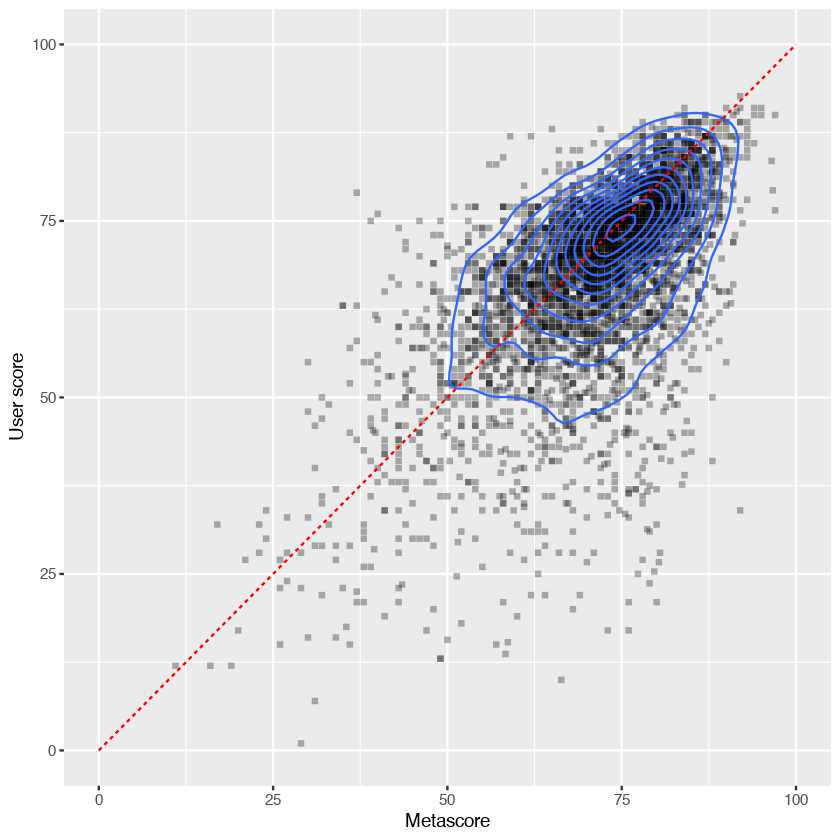

In [11]:
ggplot(games.agg, aes(x = metascore, y = user_score)) +
  geom_point(alpha = .3, pch = 15) +
  geom_density_2d() +
  geom_segment(data = data.frame(),
               inherit.aes = F,
               aes(x = 0, y = 0, xend = 100, yend = 100),
               lty = "dashed", col = "red") +
  scale_y_continuous(limits = c(0, 100)) +
  scale_x_continuous(limits = c(0, 100)) +
  labs(x = "Metascore", y = "User score", fill = "Count")

Warning message:
“Removed 4003 rows containing missing values (geom_text_repel).”

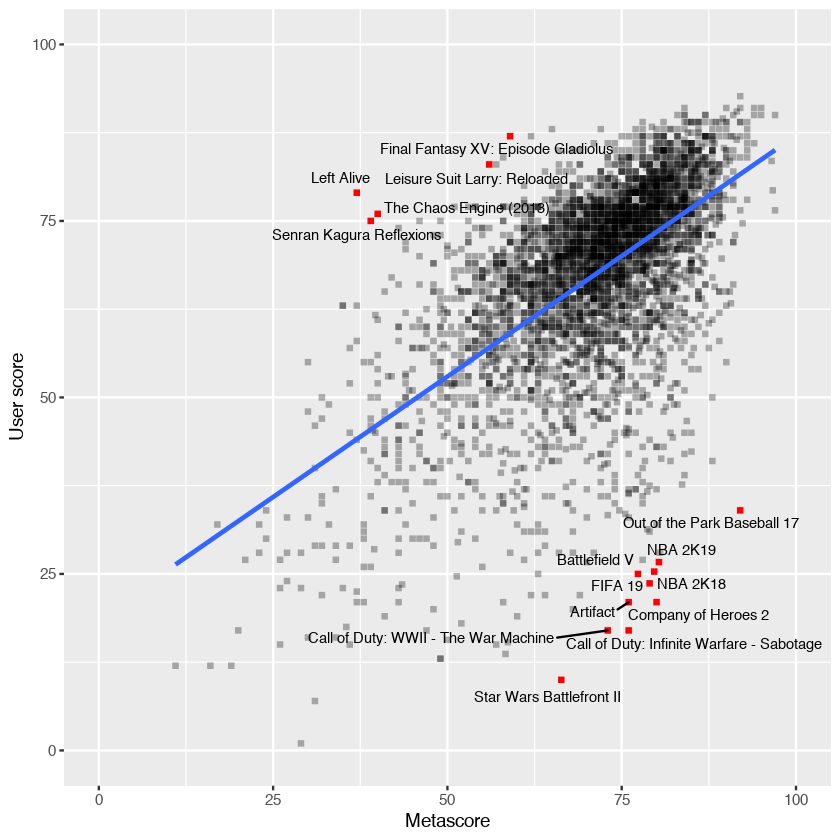

In [12]:
# 识别出 residual 正数最大的 5 个点，负数最小的 10 个点
library(ggrepel)
lmod <- lm(user_score ~ metascore, data = games.agg)

games.agg$res.user.score <- residuals(lmod)

lowest.res <- games.agg$game[order(games.agg$res.user.score)][1:10]

highest.res <- games.agg$game[order(games.agg$res.user.score,
                                    decreasing = T)][1:5]

games.agg$Label <- ifelse(games.agg$game %in% c(lowest.res, highest.res),
                          games.agg$game, NA)

ggplot(games.agg, aes(x = metascore, y = user_score)) +
  geom_point(pch = 15, aes(color = is.na(Label), alpha = is.na(Label))) +
  scale_color_manual(values = c("TRUE" = "black", "FALSE" = "red")) +
  scale_alpha_manual(values = c("TRUE" = .3, "FALSE" = 1)) +
  geom_smooth(method = "lm", formula = "y ~ x", se =  F) +
  scale_y_continuous(limits = c(0, 100)) +
  scale_x_continuous(limits = c(0, 100)) +
  geom_text_repel(aes(label = Label), force = 3, size = 3) +
  guides(col = F, alpha = F) +
  labs(x = "Metascore", y = "User score", fill = "Count")

In [ ]:
# 上面是全局分析，这里细分到 developer，并且是产量最高的 10 个；
# developer 分析：metascore、user_score 的 boxplot，并显示总体评分最低的 7 部游戏

In [43]:
dev.tab <- sort(table(games$developer), decreasing = T)
games.dev <- games[games$developer %in% names(dev.tab[1:10]),]


games.dev.agg <- aggregate(cbind(metascore, user_score) ~ game + developer,
                           FUN = mean, data = games.dev)

games.dev.agg$developer <-
  factor(games.dev.agg$developer,
         levels = names(sort(tapply(games.dev.agg$metascore,
                                    games.dev.agg$developer,
                                    mean), decreasing = T)))

games.dev.agg <- games.dev.agg[order(games.dev.agg$metascore),]
games.dev.agg[1:7, "Label"] <- games.dev.agg[1:7, "game"]

In [54]:
head(games.dev.agg)

sort(table(games$developer), decreasing = T)

,game,developer,metascore,user_score,Label
,<chr>,<fct>,<dbl>,<dbl>,<chr>
242,The LEGO Movie 2 Videogame,TT Games,60,19.00000,The LEGO Movie 2 Videogame
84,Umbrella Corps,Capcom,37,22.50000,Umbrella Corps
14,One Piece: Grand Cruise,Bandai Namco Games,35,23.00000,One Piece: Grand Cruise
110,FIFA 19,EA Sports,79,23.66667,FIFA 19
281,Minecraft: Story Mode Season Two - Episode 1: Hero in Residence,Telltale Games,70,26.66667,Minecraft: Story Mode Season Two - Episode 1: Hero in Residence
32,Tenkai Knights: Brave Battle,Bandai Namco Games,26,27.00000,Tenkai Knights: Brave Battle



                                                              Telltale Games 
                                                                         143 
                                                                      Capcom 
                                                                          98 
                                                                    Nintendo 
                                                                          49 
                                                            Ubisoft Montreal 
                                                                          47 
                                                                    TT Games 
                                                                          42 
                                                          Bandai Namco Games 
                                                                          41 
                                                               

No summary function supplied, defaulting to `mean_se()
Warning message:
“Removed 336 rows containing missing values (geom_text_repel).”

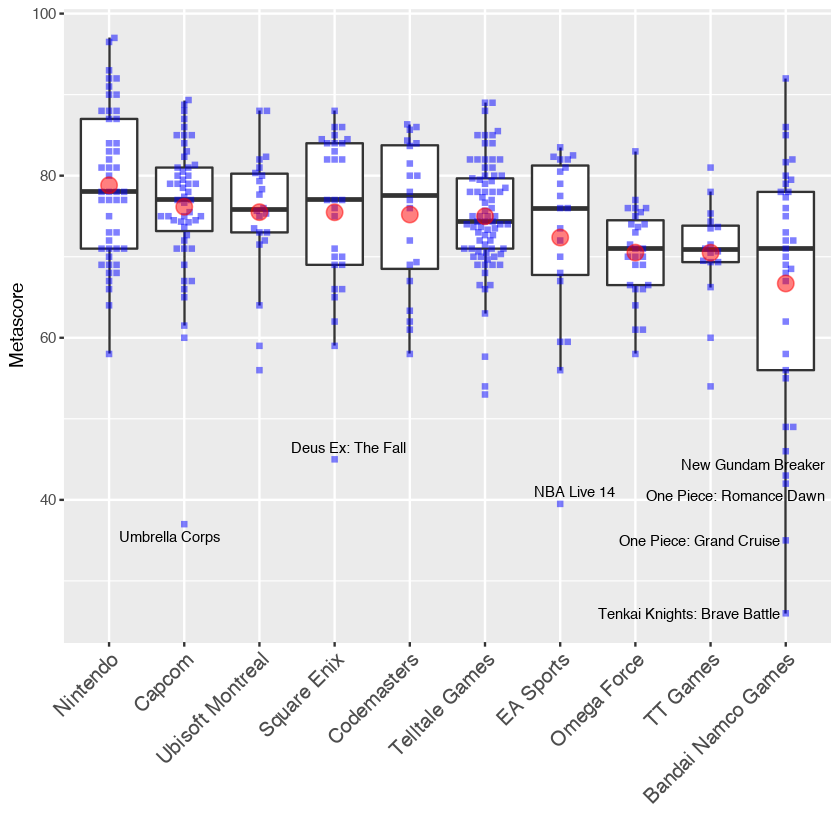

In [15]:
library(ggbeeswarm)

ggplot(games.dev.agg, aes(x = developer, y = metascore)) +
  geom_boxplot(outlier.shape = NA) +
  geom_beeswarm(alpha = .5, pch = 15, col = "blue") +
  geom_point(stat = "summary", size = 4, col = "red", alpha = .5) +
  geom_text_repel(aes(label = Label), size = 3) +
  labs(x = "", y = "Metascore") +
  theme(axis.text.x = element_text(angle = 45,
                                   hjust = 1,
                                   size = 12))

No summary function supplied, defaulting to `mean_se()
Warning message:
“Removed 336 rows containing missing values (geom_text_repel).”

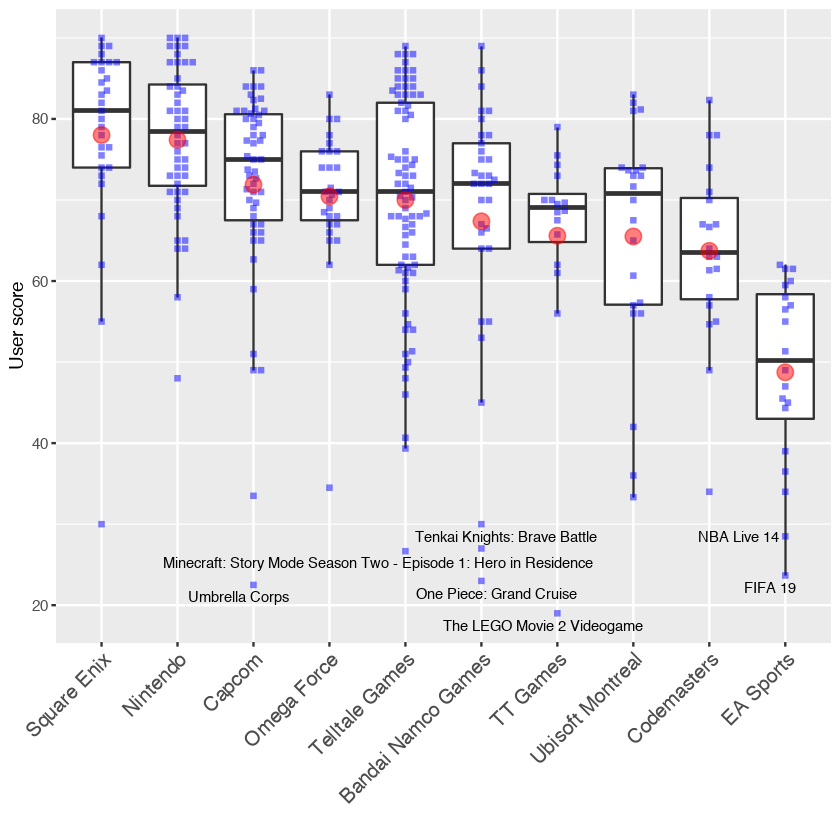

In [16]:
# 上面是 developer-metascore 的分析，这里是 user_score 分析

# 这里对 developer 的处理，只是为了使得 boxplot 从左到右按照 user_score 均值从高到低排序，对比下面没有这句话的图像
games.dev.agg$developer <-
  factor(games.dev.agg$developer,
         levels = names(sort(tapply(games.dev.agg$user_score,
                                    games.dev.agg$developer,
                                    mean), decreasing = T)))

games.dev.agg <- games.dev.agg[order(games.dev.agg$user_score),]
games.dev.agg$Label <- NA
games.dev.agg[1:7, "Label"] <- games.dev.agg[1:7, "game"]

ggplot(games.dev.agg, aes(x = developer, y = user_score)) +
  geom_boxplot(outlier.shape = NA) +
  geom_beeswarm(alpha = .5, pch = 15, col = "blue") +
  geom_point(stat = "summary", size = 4, col = "red", alpha = .5) +
  geom_text_repel(aes(label = Label), size = 3) +
  labs(x = "", y = "User score") +
  theme(axis.text.x = element_text(angle = 45,
                                   hjust = 1,
                                   size = 12))


No summary function supplied, defaulting to `mean_se()
Warning message:
“Removed 336 rows containing missing values (geom_text_repel).”

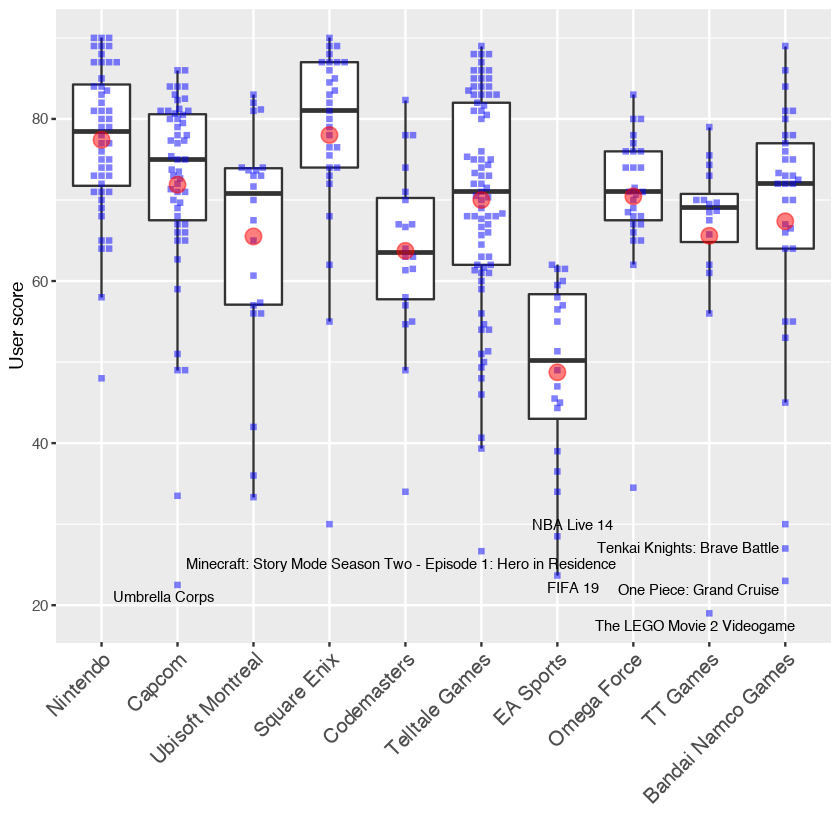

In [45]:
games.dev.agg <- games.dev.agg[order(games.dev.agg$user_score),]
games.dev.agg$Label <- NA
games.dev.agg[1:7, "Label"] <- games.dev.agg[1:7, "game"]

ggplot(games.dev.agg, aes(x = developer, y = user_score)) +
  geom_boxplot(outlier.shape = NA) +
  geom_beeswarm(alpha = .5, pch = 15, col = "blue") +
  geom_point(stat = "summary", size = 4, col = "red", alpha = .5) +
  geom_text_repel(aes(label = Label), size = 3) +
  labs(x = "", y = "User score") +
  theme(axis.text.x = element_text(angle = 45,
                                   hjust = 1,
                                   size = 12))

In [53]:
tapply(games.dev.agg$metascore, games.dev.agg$developer,
                                    mean)

# 按照 developer 排序，显示前 50 个
head(games.dev.agg[order(games.dev.agg$developer), ], 50)

# 显示特定 developer 的记录 
head(games.dev.agg[games.dev.agg$developer == 'TT Games', ])

Nintendo             Capcom   Ubisoft Montreal        Square Enix 
          78.82292           76.16144           75.50000           75.48276 
       Codemasters     Telltale Games          EA Sports        Omega Force 
          75.20833           74.98701           72.36667           70.50617 
          TT Games Bandai Namco Games 
          70.49479           66.69697

,game,developer,metascore,user_score,Label
,<chr>,<fct>,<dbl>,<dbl>,<chr>
125,1-2-Switch,Nintendo,58.0,48.0,NA
163,Tank Troopers,Nintendo,64.0,58.0,NA
144,Nintendo Labo: Toycon 02 Robot Kit,Nintendo,68.0,64.0,NA
132,Dr. Mario: Miracle Cure,Nintendo,69.0,64.0,NA
161,Super Mario Maker for Nintendo 3DS,Nintendo,73.0,65.0,NA
151,Pokemon Picross,Nintendo,75.0,65.0,NA
143,Nintendo Labo: Toycon 01 Variety Kit,Nintendo,77.0,68.0,NA
127,Animal Crossing: Happy Home Designer,Nintendo,66.0,69.0,NA
172,Wii Sports Club,Nintendo,68.0,70.0,NA


,game,developer,metascore,user_score,Label
,<chr>,<fct>,<dbl>,<dbl>,<chr>
242,The LEGO Movie 2 Videogame,TT Games,60.00000,19.00,The LEGO Movie 2 Videogame
240,LEGO The Lord of the Rings,TT Games,54.00000,56.00,NA
239,LEGO The Incredibles,TT Games,69.33333,61.00,NA
236,LEGO Marvel's Avengers,TT Games,71.00000,62.00,NA
241,LEGO Worlds,TT Games,66.25000,65.75,NA
238,LEGO The Hobbit,TT Games,70.50000,67.50,NA


In [ ]:
# 分析 score 是否随时间变化有趋势
# 结论：metascore 随时间变高，user_score 随时间变低，但是变化都很小

In [17]:
library(lubridate)
games$release <- as.Date(mdy(games$release_date))


Attaching package: ‘lubridate’

The following objects are masked from ‘package:data.table’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year

The following object is masked from ‘package:base’:

    date



In [18]:
# outlier 剔除掉，这里定义哪些是 outlier
is.outlier <- function (x) {
  x < quantile(x, .25) - 1.5 * IQR(x) |
    x > quantile(x, .75) + 1.5 * IQR(x)
}

In [19]:
games$is.out.meta <- is.outlier(games$metascore)
games$is.out.user <- is.outlier(games$user_score)

meta.mod <- lm(metascore ~ release, data = games, subset = !is.out.meta)
user.mod <- lm(user_score ~ release, data = games, subset = !is.out.meta)

In [20]:
summary(meta.mod)


Call:
lm(formula = metascore ~ release, data = games, subset = !is.out.meta)

Residuals:
     Min       1Q   Median       3Q      Max 
-28.6996  -6.0113   0.9763   7.1450  24.6318 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 5.573e+01  2.863e+00  19.467  < 2e-16 ***
release     1.015e-03  1.701e-04   5.964 2.61e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 9.677 on 5549 degrees of freedom
Multiple R-squared:  0.00637,	Adjusted R-squared:  0.006191 
F-statistic: 35.57 on 1 and 5549 DF,  p-value: 2.611e-09


In [21]:
summary(user.mod)


Call:
lm(formula = user_score ~ release, data = games, subset = !is.out.meta)

Residuals:
    Min      1Q  Median      3Q     Max 
-57.965  -6.152   2.577   8.594  25.826 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) 90.1050410  3.7616060   23.95  < 2e-16 ***
release     -0.0013233  0.0002235   -5.92 3.42e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 12.71 on 5549 degrees of freedom
Multiple R-squared:  0.006276,	Adjusted R-squared:  0.006097 
F-statistic: 35.04 on 1 and 5549 DF,  p-value: 3.416e-09


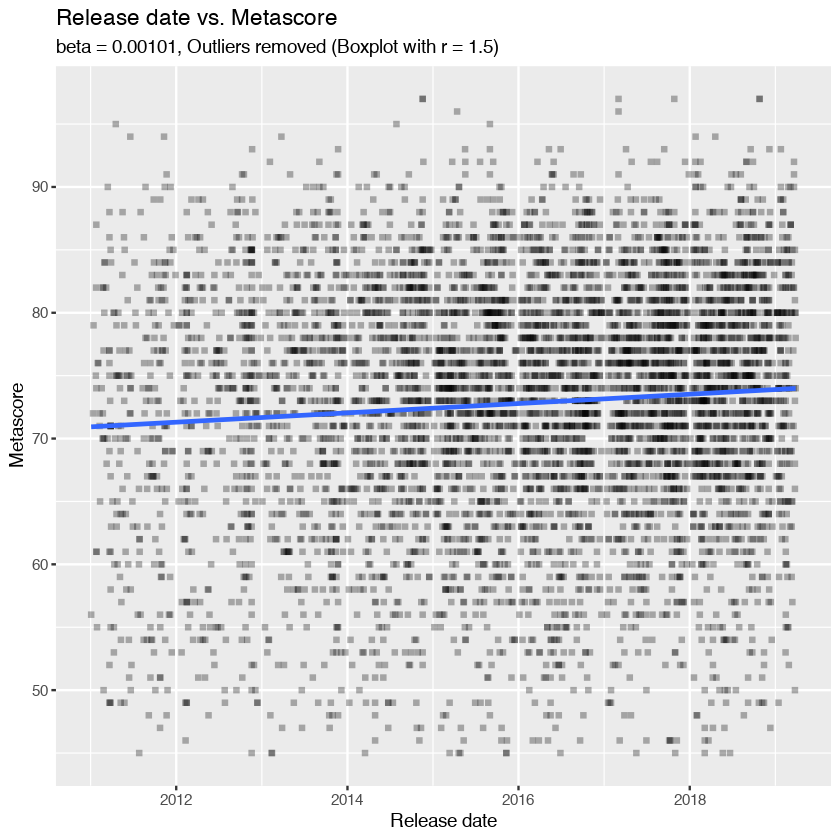

In [22]:
ggplot(games[!games$is.out.meta,], aes(x = release, y = metascore)) +
  geom_point(alpha = .3, pch = 15) +
  geom_smooth(se = F, method = "lm") +
  labs(subtitle = paste0("beta = ", signif(meta.mod$coefficients["release"], 3),
                         ", Outliers removed (Boxplot with r = 1.5)"),
       x = "Release date", y = "Metascore", title = "Release date vs. Metascore")

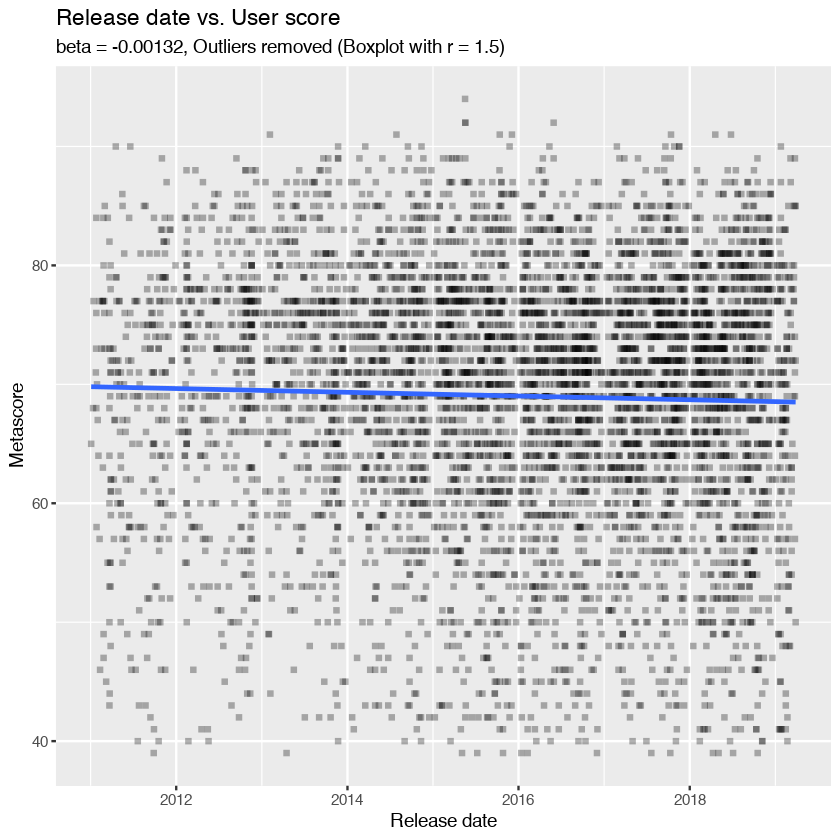

In [23]:
ggplot(games[!games$is.out.user,], aes(x = release, y = user_score)) +
  geom_point(alpha = .3, pch = 15) +
  geom_smooth(se = F, method = "lm") +
  labs(subtitle = paste0("beta = ", signif(user.mod$coefficients["release"], 3),
                         ", Outliers removed (Boxplot with r = 1.5)"),
       x = "Release date", y = "Metascore", title = "Release date vs. User score")

In [ ]:
# ESRB 

In [24]:
library(car)
sub.games <- unique(games[games$rating %in% c("E", "E10+", "M", "T") &
                            games$genre %in% c("Action", "Action Adventure",
                                               "Role-Playing", "Adventure",
                                               "Strategy", "Sports",
                                               "Simulation", "Racing",
                                               "Puzzle", "Shooter"),
                          c("rating", "genre", "game")])

sub.games$rating <- recode(sub.games$rating, "'E'='Everyone'; 'E10+'='Everyone 10+'; 'T'='Teen'; 'M'='Mature'")

# contingency table，数值其实是 计数
sub.games.tab <- table(sub.games$rating, sub.games$genre)

Loading required package: carData


In [25]:

scroll_box(kable_styling(kable(sub.games.tab)), width = "100%")

ERROR: Error in scroll_box(kable_styling(kable(sub.games.tab)), width = "100%"): could not find function "scroll_box"


In [71]:
# head(sub.games, 10)

# table(sub.games$rating)
# xtabs(~ rating, data = sub.games)

# table(sub.games$rating, sub.games$genre)
# xtabs( ~ rating + genre, data = sub.games)

order(sub.games$rating)

[1]    4    7   19   26   50   52   57   77   81   82   83   84   85   91
  [15]   94  103  106  116  120  122  123  125  127  137  143  145  147  150
  [29]  159  160  181  185  192  196  198  200  217  221  223  227  233  238
  [43]  242  244  246  252  254  258  260  262  267  269  279  284  287  290
  [57]  296  297  302  313  321  325  326  328  332  336  337  344  356  360
  [71]  361  367  370  375  380  387  388  389  391  394  395  399  401  406
  [85]  412  413  414  456  463  466  467  469  470  476  477  482  484  488
  [99]  492  496  500  505  514  518  552  556  578  580  587  589  590  599
 [113]  625  629  642  643  645  646  650  652  653  655  658  659  660  661
 [127]  664  674  681  683  690  701  704  706  710  716  717  724  731  732
 [141]  736  742  747  753  755  757  762  767  771  776  782  784  785  795
 [155]  797  798  803  806  812  816  822  823  826  833  835  836  847  850
 [169]  851  856  861  863  871  873  878  879  888  889  890  897  898  902
 [183]  908  914  915  921  933  939  943  951  960  963  974  986  992  996
 [197] 1009 1016 1019 1020 1023 1027 1030 1060 1061 1066 1070 1072 1078 1081
 [211] 1082 1083 1085 1107 1111 1118 1119 1124 1129 1137 1139 1141 1143 1145
 [225] 1152 1153 1154 1157 1159 1163 1166 1172 1177 1178 1179 1191 1192 1198
 [239] 1202 1207 1212 1213 1220 1229 1230 1232 1234 1237 1240 1249 1250 1253
 [253] 1266 1267 1269 1270 1282 1283 1284 1285 1295 1296 1297 1298 1305 1309
 [267] 1324 1328 1341 1342 1344 1345 1346 1352 1353 1364 1370 1371 1378 1383
 [281] 1387 1388 1392 1396 1411 1417 1418 1425 1429 1440 1447 1455 1456 1458
 [295] 1460 1464 1470 1485 1492 1493 1494 1507 1518 1520 1524 1532 1539 1545
 [309] 1561 1563 1566 1568 1584 1586 1599 1605 1606 1612 1613 1620 1630 1642
 [323] 1650 1652 1674 1679 1688 1690 1696 1698 1700 1707 1710 1713 1714 1715
 [337] 1721 1729 1730 1736 1740 1745 1748 1754 1755 1757 1763 1769 1778 1780
 [351] 1786 1789 1804 1807 1810 1821 1823 1825 1836 1845 1846 1850 1851 1856
 [365] 1860 1862 1864 1875 1878 1883 1886 1896 1904 1906 1907 1910 1911 1913
 [379] 1914 1916 1926 1927 1929 1931 1933 1936 1950 1953 1955 1969 1978 1988
 [393] 1992 2000 2002 2003 2004 2005 2021 2022 2025 2039 2040 2044 2046 2049
 [407] 2051 2053 2056 2066 2074 2080 2093 2099 2106 2109 2111 2116 2120 2125
 [421] 2133 2138 2140 2147 2160 2163 2167 2180 2182 2190 2197 2202 2204 2209
 [435] 2210 2214 2218 2219 2223 2225 2228 2229 2230 2233 2235 2240 2247 2248
 [449] 2262 2263 2274 2280 2284 2285 2303 2306 2309 2312 2320 2323 2327 2328
 [463] 2333 2340 2345 2349 2350 2356 2359 2360 2361 2368 2375 2379 2383 2392
 [477] 2397 2401 2404 2410 2411 2412 2419 2423 2431 2437 2451 2454 2462 2463
 [491] 2470 2471 2476 2479 2487 2493 2496 2501 2502 2504 2517 2518 2523 2531
 [505] 2537 2539 2547 2548 2549 2550 2557 2560 2570 2575 2597 2600 2601 2603
 [519] 2606 2607 2609 2610 2620 2637 2641    1   13   20   28   30   33   35
 [533]   36   44   58   60   68   70   73   75   87   92  131  132  133  134
 [547]  135  138  141  163  164  168  170  179  187  188  199  201  210  219
 [561]  220  225  231  237  248  251  255  261  272  274  276  282  283  291
 [575]  292  293  295  300  303  310  317  329  333  334  338  345  346  348
 [589]  349  357  363  366  368  369  373  379  381  383  390  393  403  407
 [603]  411  416  418  423  425  426  428  433  443  462  486  487  494  501
 [617]  502  503  507  512  516  517  519  521  525  532  535  538  540  554
 [631]  557  558  560  562  573  581  592  594  600  604  609  611  612  613
 [645]  614  615  617  621  622  630  632  633  638  640  644  648  649  654
 [659]  666  677  685  689  693  694  697  708  714  725  727  733  734  738
 [673]  741  744  748  752  760  764  770  780  805  809  817  824  838  839
 [687]  840  853  855  860  866  868  869  874  877  880  892  901  910  926
 [701]  928  931  935  940  959  962  964  965  971  972  975  993  999 1021
 [715] 1024 1028 1037 1043 1047 1051 1052 1056 1063 1068 1069 1076 1080 1088

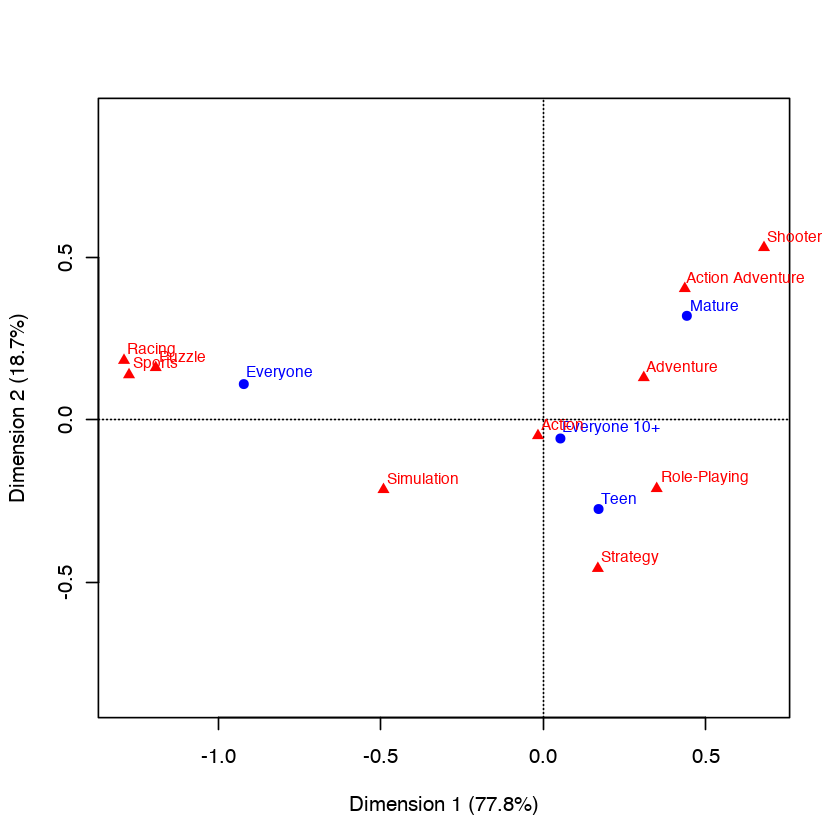

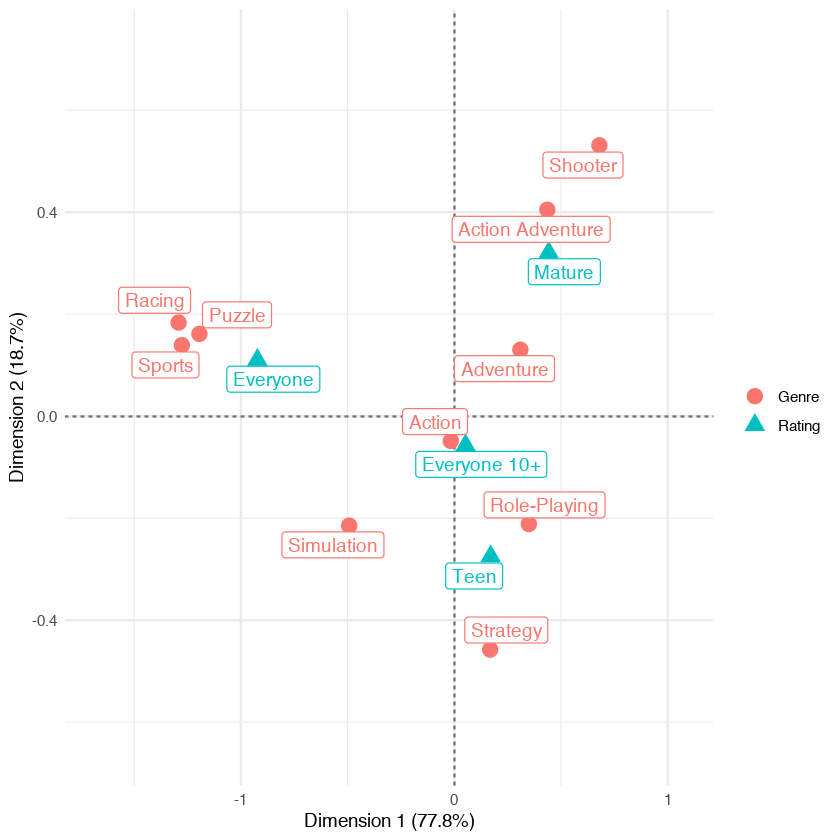

In [30]:
# 主成分分析，并用前两个维度做散点图
library(ca)
ca.fit <- ca(sub.games.tab) # do the ca
ca.sum <- summary(ca.fit)   # needed later for dimension percentages
ca.plot.obj <- plot(ca.fit)
make.ca.plot.df <- function (ca.plot.obj,
                             row.lab = "Rows",
                             col.lab = "Columns") {
  df <- data.frame(Label = c(rownames(ca.plot.obj$rows),
                             rownames(ca.plot.obj$cols)),
                   Dim1 = c(ca.plot.obj$rows[,1], ca.plot.obj$cols[,1]),
                   Dim2 = c(ca.plot.obj$rows[,2], ca.plot.obj$cols[,2]),
                   Variable = c(rep(row.lab, nrow(ca.plot.obj$rows)),
                                rep(col.lab, nrow(ca.plot.obj$cols))))
  rownames(df) <- 1:nrow(df)
  df
}
# Create plotting data.frame for ggplot
ca.plot.df <- make.ca.plot.df(ca.plot.obj,
                              row.lab = "Rating",
                              col.lab = "Genre")
# Extract percentage of variance explained for dims 
dim.var.percs <- ca.sum$scree[,"values2"]
library(ggrepel)
ggplot(ca.plot.df, aes(x = Dim1, y = Dim2,
                       col = Variable, shape = Variable,
                       label = Label)) +
  geom_vline(xintercept = 0, lty = "dashed", alpha = .5) +
  geom_hline(yintercept = 0, lty = "dashed", alpha = .5) +
  geom_point(size = 4) +
  scale_x_continuous(limits = range(ca.plot.df$Dim1) + c(diff(range(ca.plot.df$Dim1)) * -0.2,
                                                         diff(range(ca.plot.df$Dim1)) * 0.2)) +
  scale_y_continuous(limits = range(ca.plot.df$Dim2) + c(diff(range(ca.plot.df$Dim2)) * -0.2,
                                                         diff(range(ca.plot.df$Dim2)) * 0.2)) +
  geom_label_repel(show.legend = F, segment.alpha = .5) +
  guides(colour = guide_legend(override.aes = list(size = 4))) +
  labs(x = paste0("Dimension 1 (", signif(dim.var.percs[1], 3), "%)"),
       y = paste0("Dimension 2 (", signif(dim.var.percs[2], 3), "%)"),
       col = "", shape = "") +
  theme_minimal()